> If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor

> A group of pre dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method

# Voting Classifier

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1)

<p align='center'>
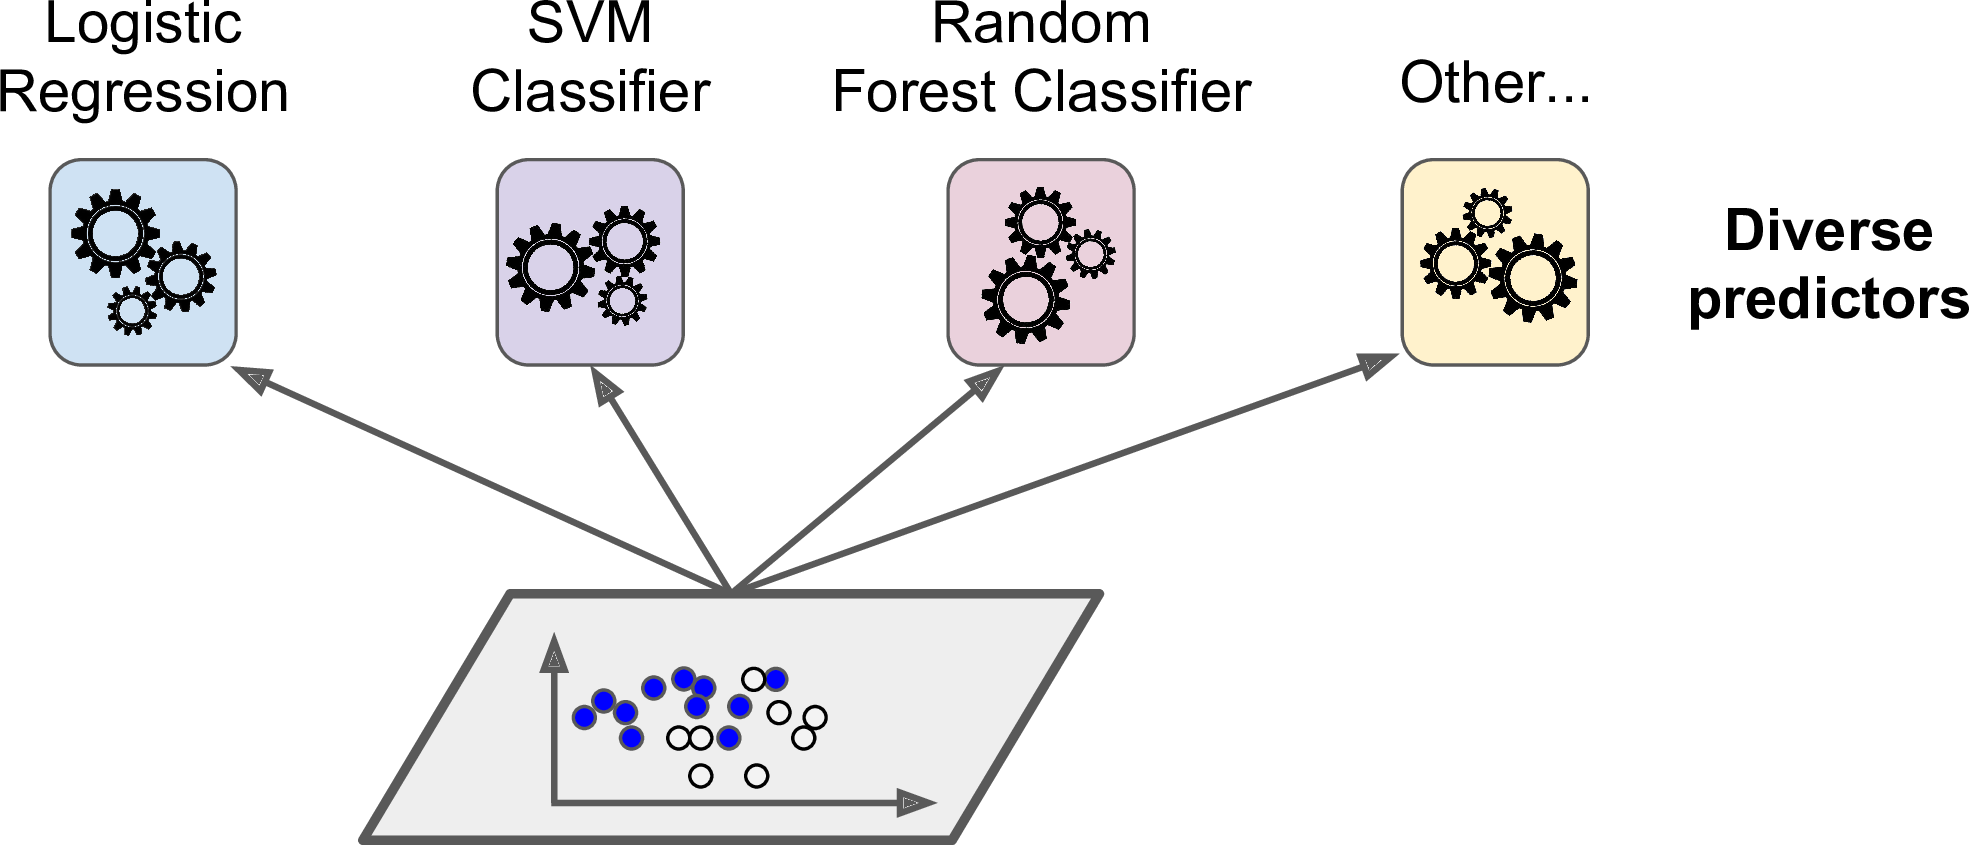
</p>
Figure 7-1. Training diverse classifier

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier (see Figure 7-2)

<p align='center'>
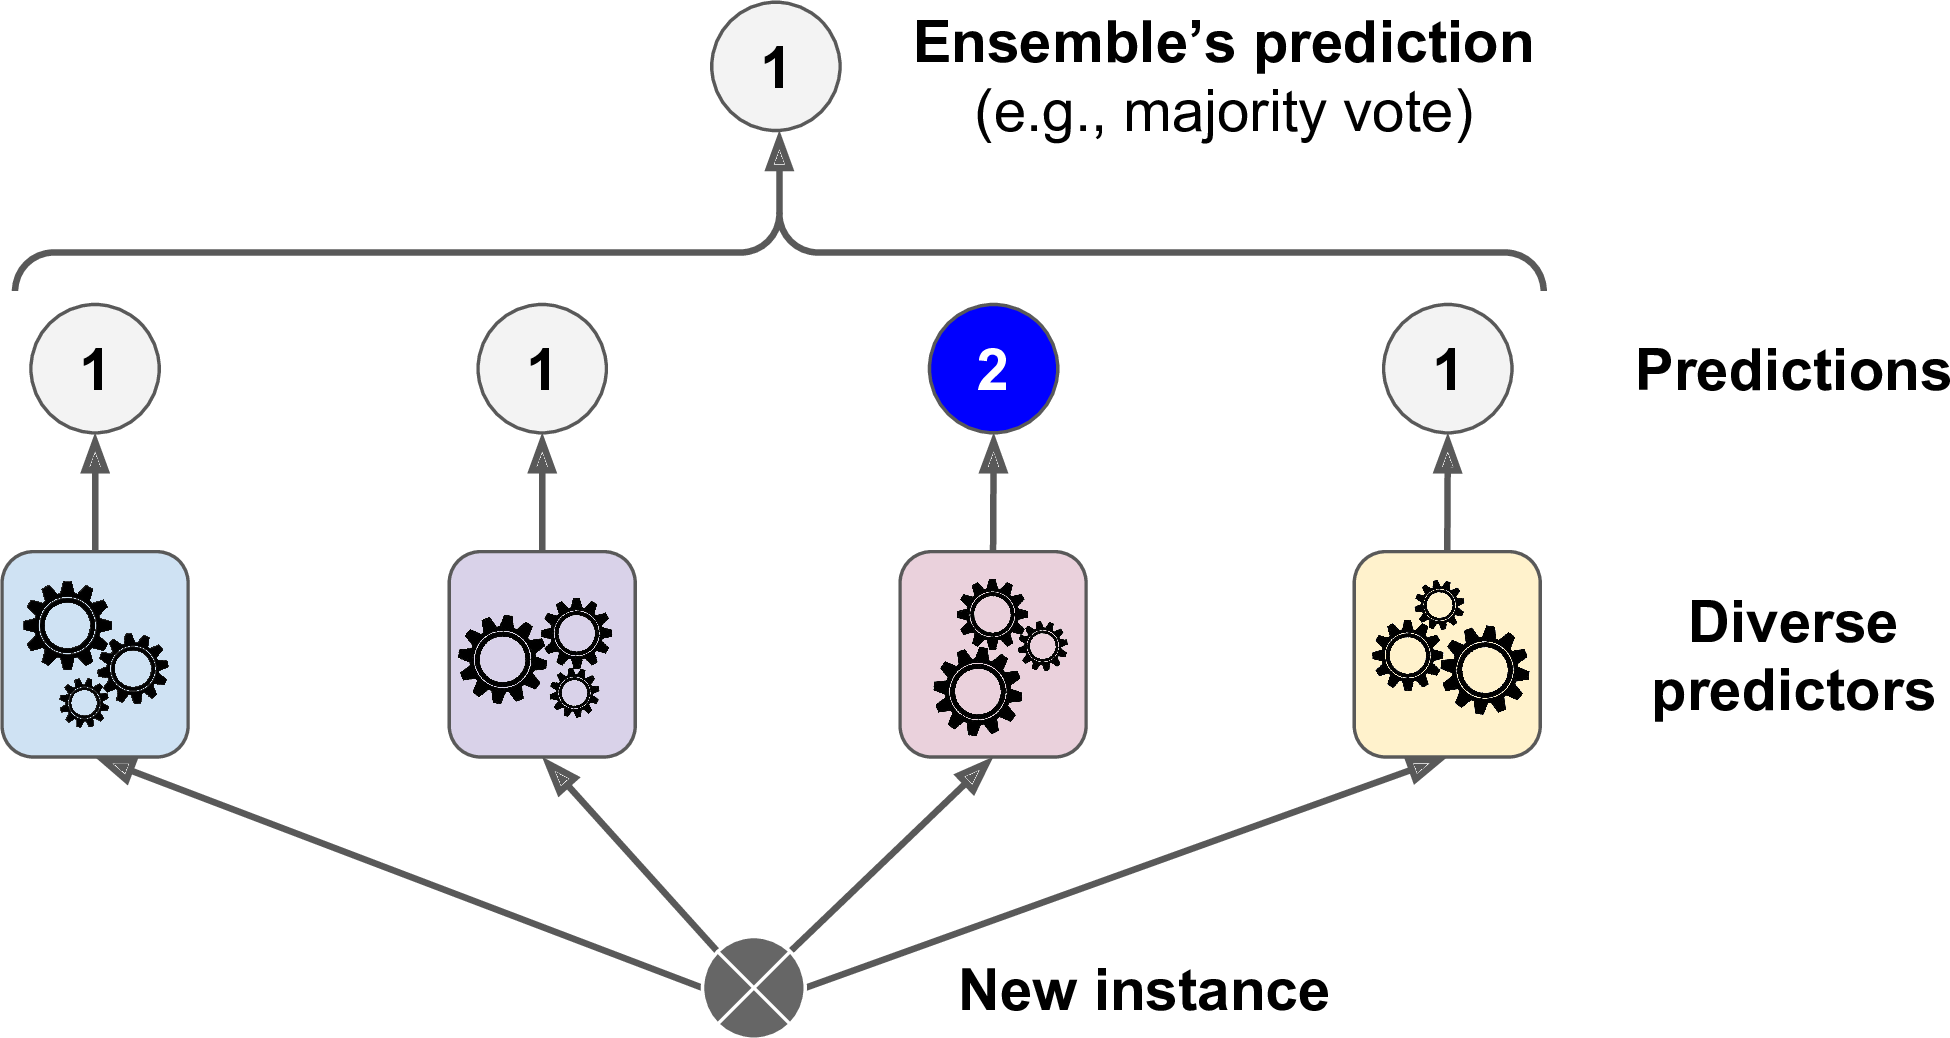
</p>
Figure 7-2. Hard voting classifier predictions

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse

How is this possible? The following analogy can help shed some light on this mystery

Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%

The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%)

Figure 7-3 shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventu ally all 10 series end up so close to 51% that they are consistently above 50%

<p align='center'>
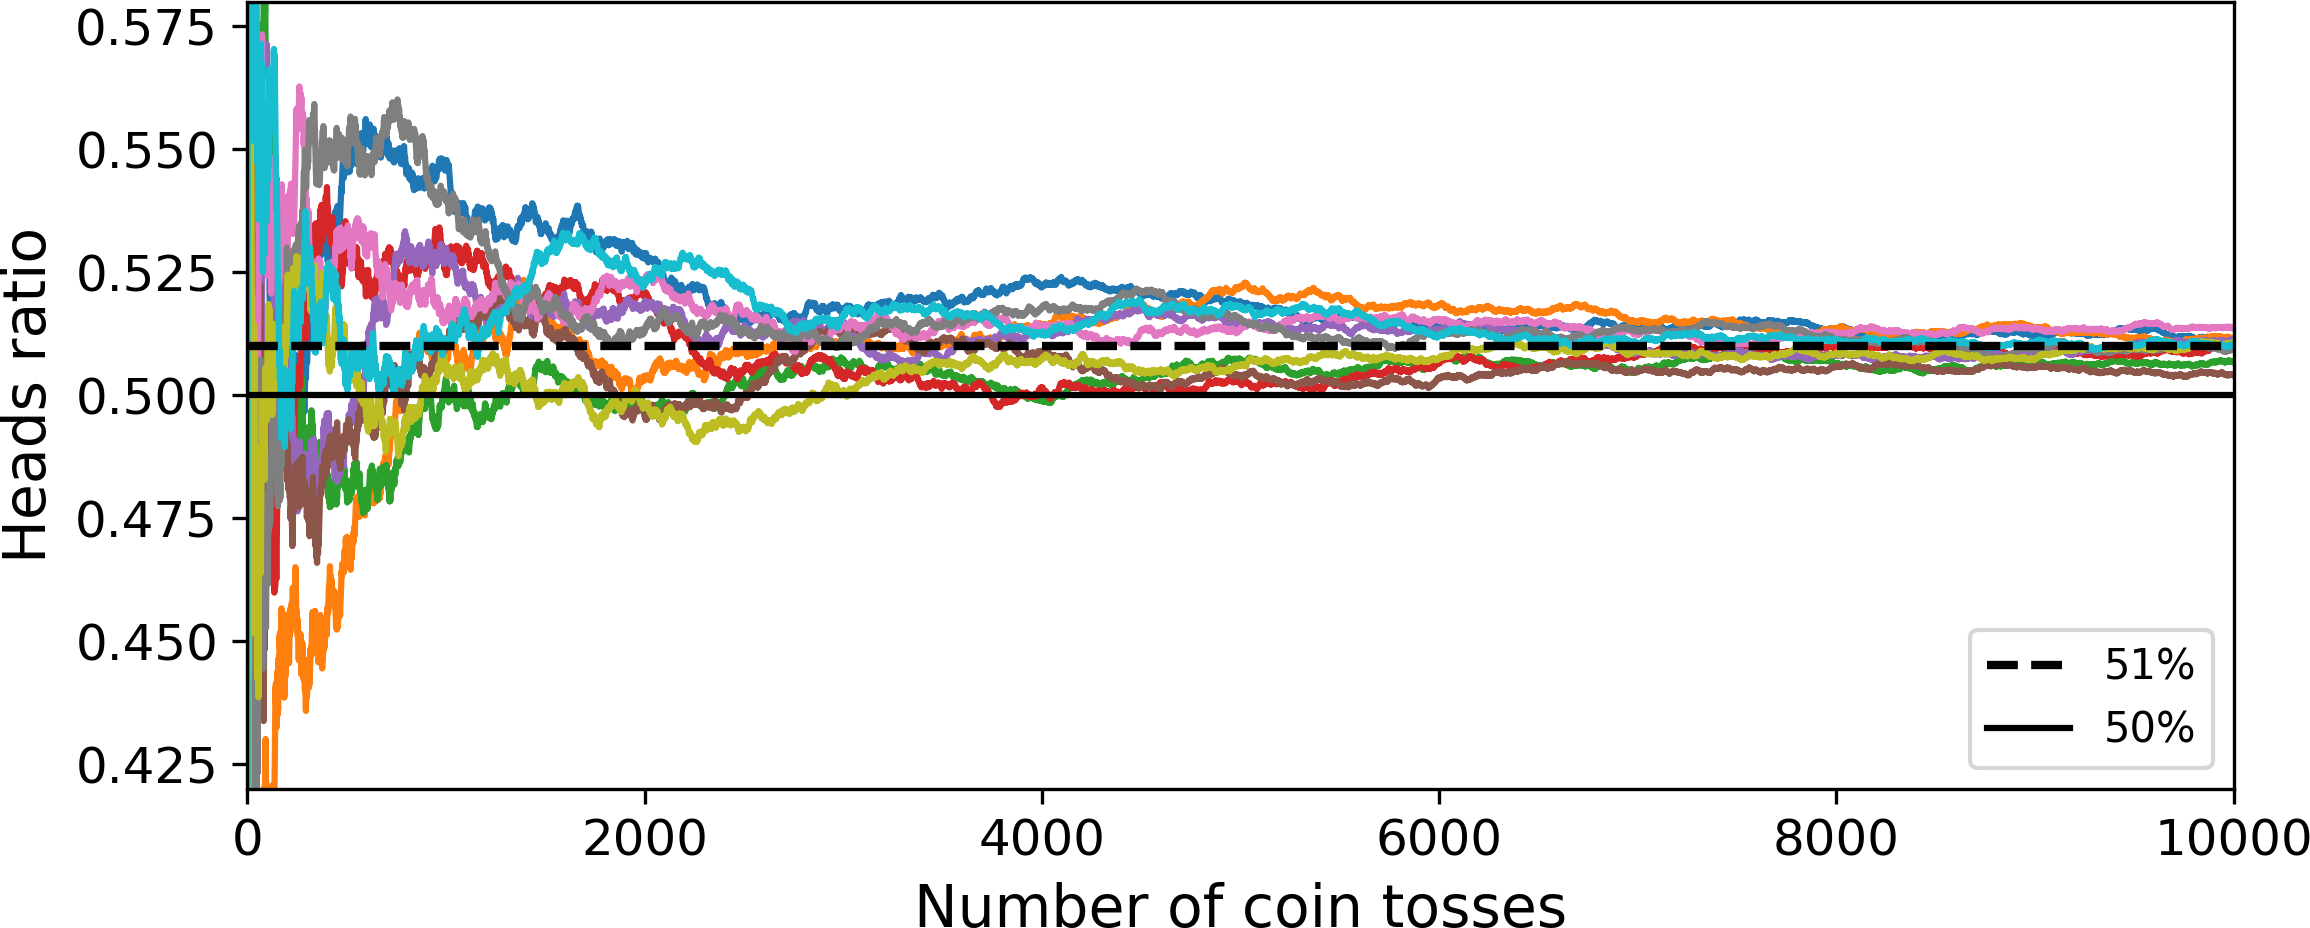
</p>
Figure 7-3. The law of large numbers

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset, introduced in Chapter 5)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

Let’s look at each classifier’s accuracy on the test set

In [15]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.888
SVC 0.888
VotingClassifier 0.896


There you have it! The voting classifier slightly outperforms all the individual classifiers

If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called sof voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes


All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities

This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method)

If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy



# Bagging and Pasting


One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set

When sampling is performed with replacement, this method is called bagging (meaning that the individual data points can be chosen more than once) (short for bootstrap aggregating). When sampling is performed without replacement (each subset of the sample can be used once at most), it is called pasting

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure 7-4

<p align='center'>
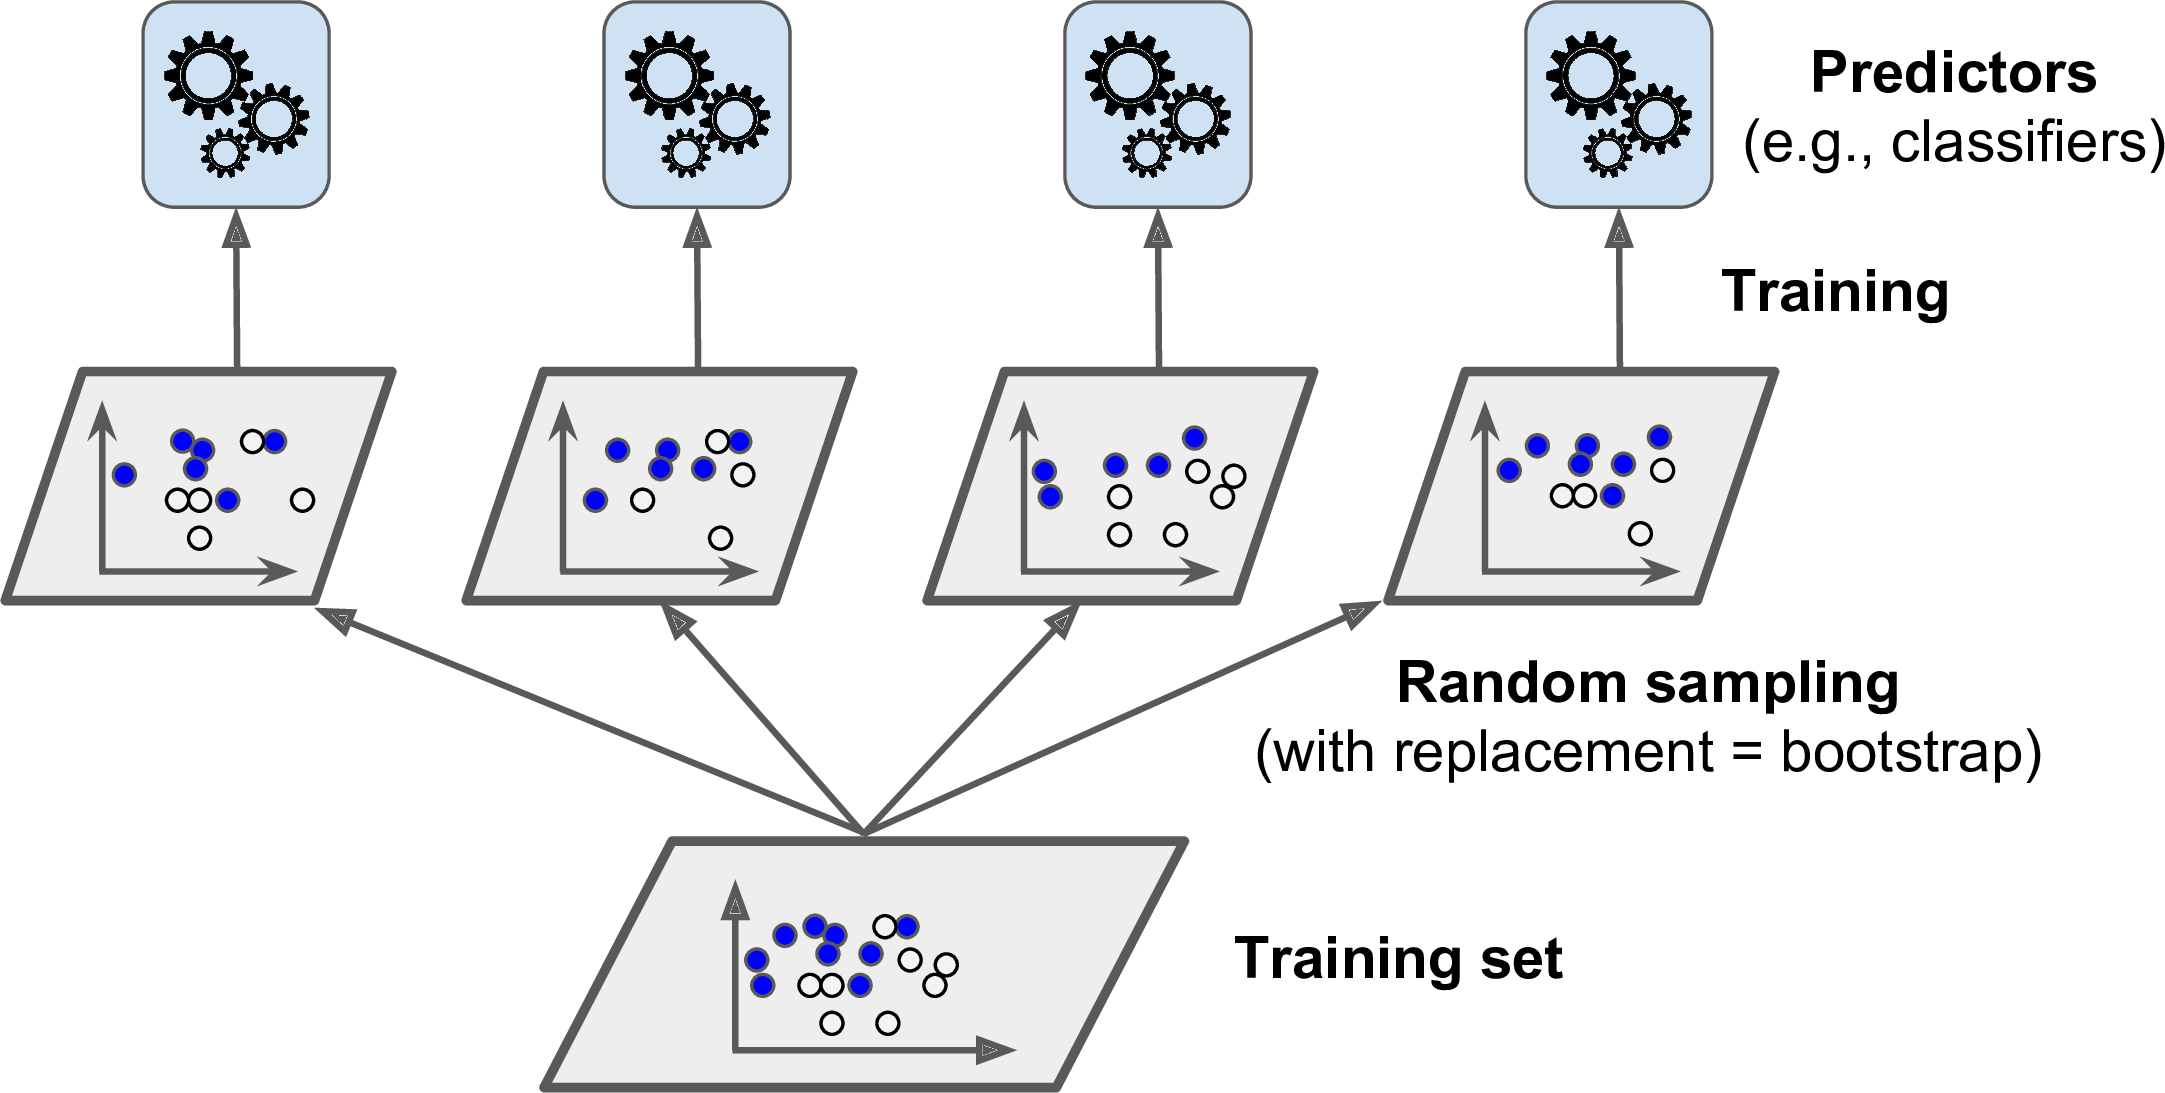
</p>
Figure 7-4. Pasting/bagging training set sampling and training

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors

The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set

As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well

# Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression)

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False)

The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

Figure 7-5 compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular)

<p align='center'>
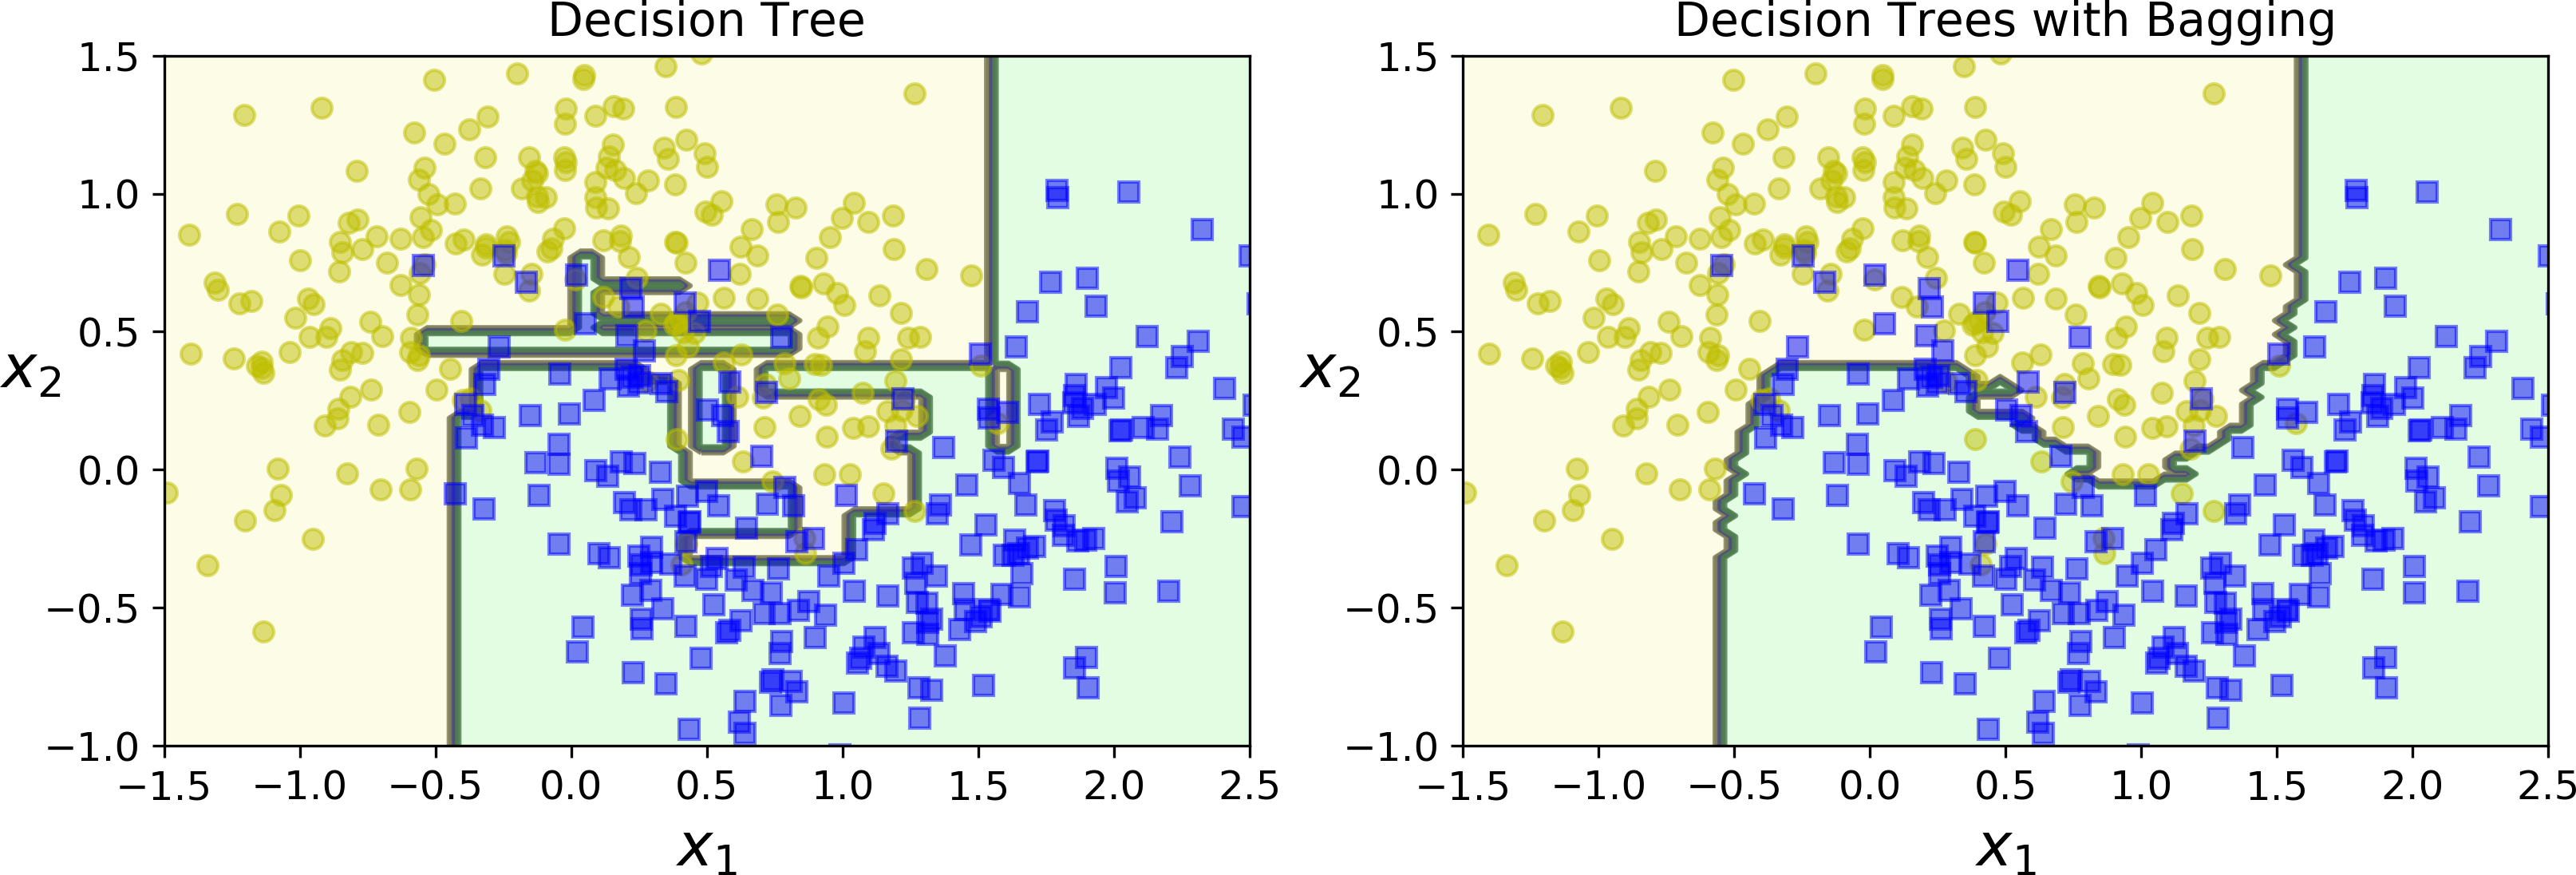
</p>
Figure 7-5. A single Decision Tree versus a bagging ensemble of 500 trees

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced

Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross validation to evaluate both bagging and pasting and select the one that works best

# Out-of-Bag Evaluation